# Tutorial for data processing (P2530)

The module is called `processing` and it should be imported. The code is not packaged, so `processing.py` should be in the same directory as the notebook you are running (unless you use importlib or add path).

In [1]:
import processing as pr

Other modules we use in this tutorial are:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import extra_data as ed
import extra_geom as eg
import toolbox_scs.detectors as tbdet

In the next cell, we specify:

- proposal number
- run number
- (if necessary) dark run number

In [3]:
proposal = 2530
run = 51
dark_run = 49

## Step 0: Getting necessary files

In `usr/Shared` is `scs-processing` directory which contains all necessary files for processing. Please copy that directory to your own directory and run all processing from there.

Processing is going to create `processed_runs_xgm` directory inside `yourusername/scs-processing` and all files you process will be stored there. (We are probably going to centralise all processed data so that it is easily accessible to everybody, but for that we need somebody with right permissions to help us.)


## Step 1: Processing data

Before data can be accessed and analysied in this notebook, it has to be processed. There are two types of processing, which we call:

- standard (no XGM normalisation)
- normalised (with XGM normalisation)

Bash script for processing runs is `process_run.sh`, which is executed as:

    $ ./process_run.sh <run> <darkrun> <xgm-lower-threshold> <xgm-upper-threshold>
    
This script will submit 16 jobs to the queue (1 per DSSC module) and perform the processing in parallel.

There is a slight change in how this script is called depending if we want to perform standard or normalised processing. More precisely, three zeros (0 0 0) follow the run number, standard processing is performed. Otherwise if dark run is not zero, normalised processing is done.

### Examples:

#### 1.1 Standard processing

In order to perform standard processing of a single run, it is not required to provide the dark run and XGM threshold values. This is because the dark run can be included later, which is not the case for normalised processing.

Let us say we want to process run number 51 without normalisation. This is done as:

    ./process_run.sh 51 0 0 0
    
All dark runs are processed this way. For instance, run 49 is a dark run and before it can be used in normalised processing, it has to be processed in a "standard way":

    ./process_run.sh 49 0 0 0

#### 1.2 Normalised processing

To process run 51 with normalisation, we use

    ./process_run.sh 51 49 0.1 0.5
    
where 49 is its corresponding dark run, 0.1 is the lower XGM threshold and 0.5 the upper XGM threshold. (This assumes we already processed dark run 49.)

The normalisation is done per module and averaging is only done over trains. The individual pulses are kept separatly.

For runs
- Ri is a run with actual images (X-ray pulses) with the sequence (Ri_image, Ri_intradark, Ri_image, ...)
- Rd is a dark run with sequence (Rd_dark, Rd_intradark, Rd_dark, ...)

we now have pulse-resolved images with the data normalised as:

    average_over_trains( {Ri_image - average_over_trains(Ri_indradark) - [average_over_trains(Rd_dark) - average_over_trains(Rd_intradark)]} / XGM )

Only frames with XGM values between lower and upper threshold are processed.

## Step 2: Reading the processed data

After processing data, we read it. The directory where processed data is saved is `processed_runs_xgm`.

#### 2.1 Standard processing

In "standard" processed data, `image_average` and `dark_average` are saved and they are loaded using the cell. Please note that we specify `std` for run type.

In [4]:
pulse_images = pr.concat_module_images(dirname='processed_runs_xgm', 
                                       run=run,
                                       run_type='std',
                                       image_type='image_average')

pulse_dark = pr.concat_module_images(dirname='processed_runs_xgm',
                                     run=run,
                                     run_type='std',
                                     image_type='dark_average')

Similarly, we can load the dark run (49) data if we want to add it to the formula:

In [5]:
dark_images = pr.concat_module_images(dirname='processed_runs_xgm',
                                      run=dark_run,
                                      run_type='std',
                                      image_type='image_average')

dark_dark = pr.concat_module_images(dirname='processed_runs_xgm',
                                    run=dark_run,
                                    run_type='std',
                                    image_type='dark_average')

The data is frame-resolved and it must be averaged:. The formula we use:

In [6]:
image_std = (np.mean(pulse_images, axis=0) - np.mean(pulse_dark, axis=0) -
            (np.mean(dark_images, axis=0) - np.mean(dark_dark, axis=0)))

#### 2.2 Normalised processing

Here we load only one run, since the dark run was used in processing:

In [7]:
normalised = pr.concat_module_images(dirname='processed_runs_xgm',
                                     run=run,
                                     run_type='normalised',
                                     image_type='normalised_average')

The data is frame-resolved and it must be averaged:

In [8]:
image_normalised = np.mean(normalised, axis=0)

## Step 3: Plotting the data

From now on, plotting is taken from previous tutorials (`shared/tutorial_analysis.ipynb`). For example:

In [9]:
quad_pos = [(-123.0 , 1.72),  # TR
            (-130.0, -110.18),  # BR
            (1.4, -122.78),  # BL
            (2.2, -4.08)  # TL
            ]

geopath = '/gpfs/exfel/sw/software/git/EXtra-geom/' \
                  'docs/dssc_geo_june19.h5'
geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

masklist = [(4, 1, 0),
            (13, 0, 0),
            (1, 0, 6)]

dssc_mask = tbdet.quickmask_DSSC_ASIC(geom, masklist)

#### 3.1 Standard processing

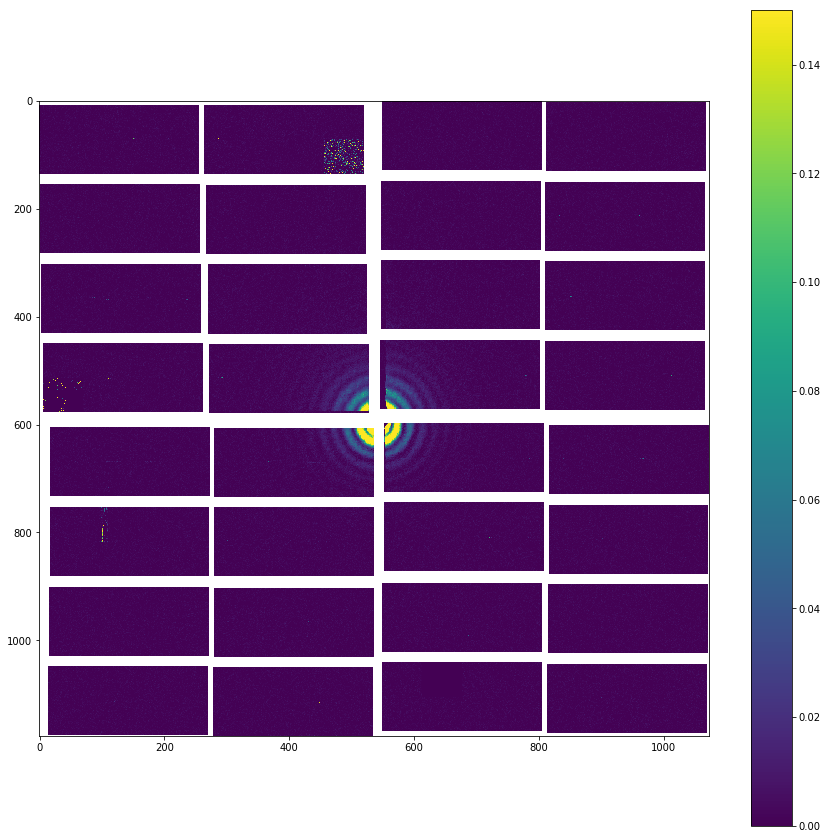

In [10]:
preview_image, center = geom.position_modules_fast(image_std)

fig = plt.figure(figsize=(15, 15))
plt.imshow(preview_image, vmin=0, vmax=0.15, aspect=204.0/236.0)
plt.colorbar()

#### 3.2 Normalised processing

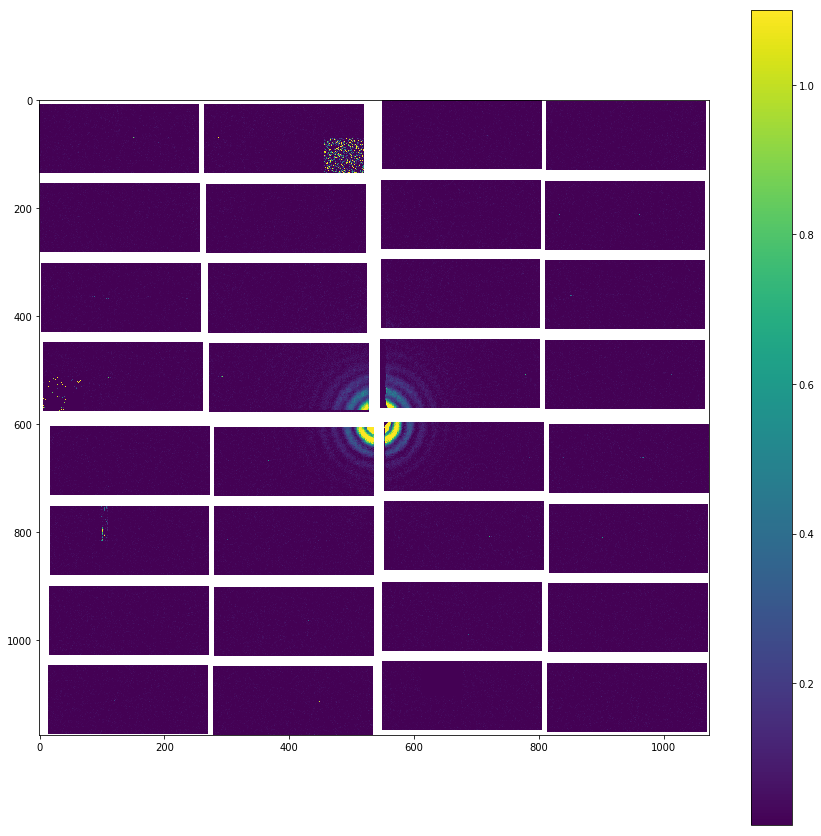

In [11]:
preview_image, center = geom.position_modules_fast(image_normalised)

fig = plt.figure(figsize=(15, 15))
plt.imshow(preview_image, vmin=0.01, vmax=1.1, aspect=204.0/236.0)
plt.colorbar()

## Supplementary info

Before processing run using normalisation, to more easily determine the values of XGM threshold, XGM data can be accessed:

In [12]:
pattern = ['image', 'dark'] * 99 + ['end_run']
module = pr.Module(proposal=proposal, run=run, module=0, pattern=pattern)

xgm_values = module.xgm.data

This data can now be plotted. For instance:

(array([2.91523e+05, 2.30441e+05, 5.79000e+04, 1.37920e+04, 3.09700e+03,
        6.48000e+02, 1.33000e+02, 2.40000e+01, 4.00000e+00, 2.00000e+00]),
 array([-0.01394975,  0.1609049 ,  0.33575955,  0.5106142 ,  0.68546885,
         0.8603235 ,  1.0351782 ,  1.2100328 ,  1.3848875 ,  1.5597421 ,
         1.7345967 ], dtype=float32),
 <a list of 10 Patch objects>)

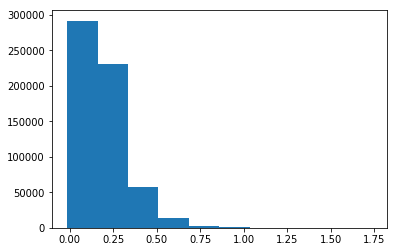

In [13]:
plt.hist(xgm_values)